In [2]:
!pip install torchvision 

In [94]:
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim 

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchvision.datasets.folder import DatasetFolder
from torch.utils.data import Subset

In [90]:
BATCH_SIZE = 32
SIZE = 244
EPOCH=5

In [102]:

# applying the transformations 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(SIZE, scale=(0.8, 1.0)),       # random zoom/crop
    transforms.RandomHorizontalFlip(p=0.5),                     # horizontal flip
    transforms.RandomVerticalFlip(p=0.3),                       # optional: vertical flip
    transforms.RandomRotation(degrees=20),                      # wider angle range
    transforms.ColorJitter(brightness=0.2, contrast=0.2,        # lighting variation
                           saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),   # shift slightly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root='./augmented')

#splliting the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_idxs, test_idxs = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset = Subset(datasets.ImageFolder(root='./augmented', transform=train_transform), train_idxs.indices)
test_dataset = Subset(datasets.ImageFolder(root='./augmented', transform=test_transform), test_idxs.indices)

# shuffle to avoid model from learning the order of the images
# num_workers to use myultiple CPU threads 
trainLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# not using shuffling to make sure the same images are used for evaluation each time
testLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

for images, labels in trainLoader: 
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 244, 244]) torch.Size([32])


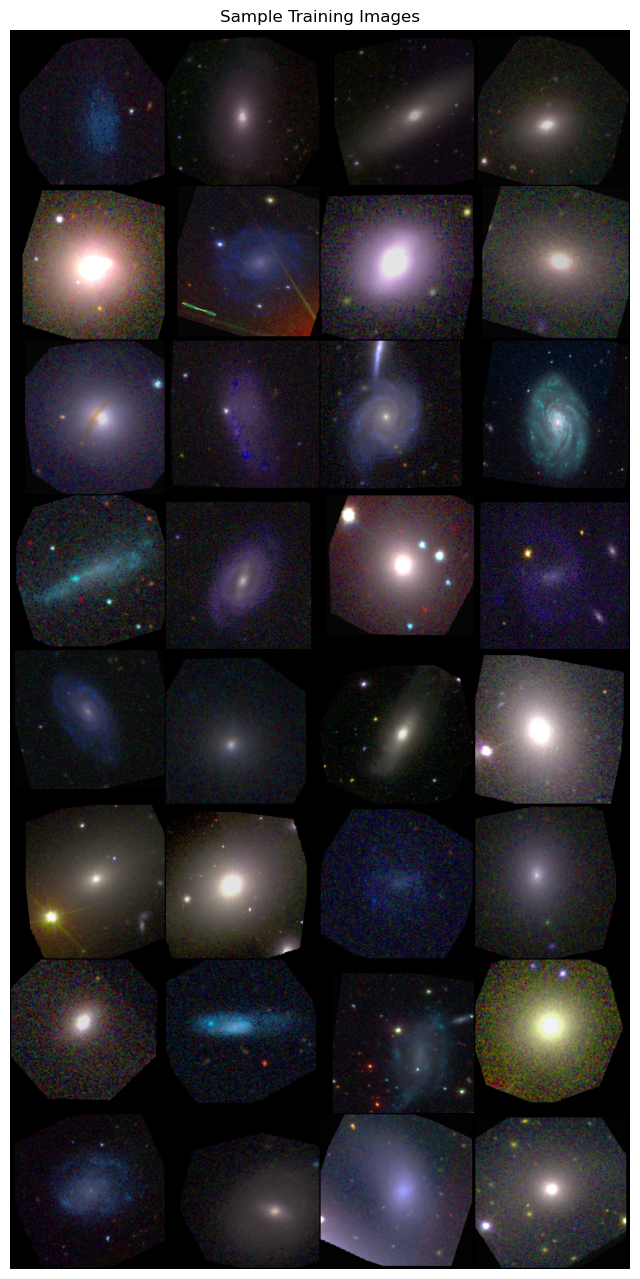

In [103]:
#displaying the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get one batch
images, labels = next(iter(trainLoader))

images = images * 0.5 + 0.5

# Make a grid of images (for nice display)
img_grid = torchvision.utils.make_grid(images, nrow=4, padding=2)

# Convert to NumPy for display
np_img = img_grid.numpy()
np_img = np.transpose(np_img, (1, 2, 0))  # convert from [C, H, W] to [H, W, C]

# Undo normalization if needed (if you applied Normalize before)
# For example, if normalized with mean=0.5, std=0.5:
# np_img = np_img * 0.5 + 0.5

# Display image grid
plt.figure(figsize=(8, 20))
plt.imshow(np_img)
plt.axis('off')
plt.title("Sample Training Images")
plt.show()


In [104]:
# importing the model
model = models.mobilenet_v3_small(weights = 'DEFAULT', pretrained=True)

# modifying the head 
model.classifier = nn.Sequential(
    # mobile net output 576
    nn.Linear(576, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 4)  # 4 classes
)

for paramedics in model.features.parameters():
    paramedics.required_grad = False

# unfreezing the last layers to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [105]:
device = ""
# Selecting the best available device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU via Metal
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # CPU fallback

print("Using device:", device)

# Moving model to the selected device
model = model.to(device)
model = model.float()

# moving the images and labels to the device so they can be processed together
for images, labels in trainLoader: 
    images = images.to(device)
    labesl = labels.to(device)

print(images.device, images.dtype)
print(next(model.parameters()).device, next(model.parameters()).dtype)

Using device: mps
mps:0 torch.float32
mps:0 torch.float32


In [106]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()
    
    total_loss = 0
    for images, labels in tqdm(train_dataloader):
        images = images.to(device).float()
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

def test(model, test_dataloader, criterion):
    model.eval()
    
    with torch.no_grad():

        total_loss = 0
        correct = 0

        for images, labels in tqdm(test_dataloader):
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model(images)

            
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / len(test_dataloader.dataset)
        avg_loss = total_loss / len(test_dataloader)
        
    return avg_loss, accuracy

In [107]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    
    for epoch in range(num_epochs):
        
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        test_loss, accuracy = test(model, test_dataloader, criterion)

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy:{accuracy:.2f}%')

In [110]:
train(model, trainLoader, testLoader, criterion, optimizer, 20)

100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.57it/s]


Epoch: 1/20 | Train Loss: 0.1784 | Test Loss: 0.1830 | Accuracy:92.11%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 2/20 | Train Loss: 0.1706 | Test Loss: 0.2180 | Accuracy:90.89%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 3/20 | Train Loss: 0.1706 | Test Loss: 0.2926 | Accuracy:88.77%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 4/20 | Train Loss: 0.1770 | Test Loss: 0.1977 | Accuracy:90.81%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 5/20 | Train Loss: 0.1682 | Test Loss: 0.2158 | Accuracy:90.48%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 6/20 | Train Loss: 0.1500 | Test Loss: 0.1794 | Accuracy:92.51%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 7/20 | Train Loss: 0.1605 | Test Loss: 0.1663 | Accuracy:93.08%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 8/20 | Train Loss: 0.1431 | Test Loss: 0.1929 | Accuracy:91.54%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 9/20 | Train Loss: 0.1427 | Test Loss: 0.1561 | Accuracy:93.33%


100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.61it/s]


Epoch: 10/20 | Train Loss: 0.1320 | Test Loss: 0.1855 | Accuracy:92.76%


  0%|                                                    | 0/39 [00:02<?, ?it/s]
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/__init__.py", line 405, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 463, in _lock_unlock_module
KeyboardInterrupt


KeyboardInterrupt: 